# Region spotting for B. Janz 🇨🇳 🤓 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import proplot as plot
import xarray as xr
import pandas as pd
import requests
import geopandas as gpd
import matplotlib
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import contextily as ctx

In [3]:
def my_round(x, res=0.25):
    V = int(1/res)
    return round(x*V)/V

In [4]:
# boundary info from https://nominatim.openstreetmap.org based on OSM data, filtered for boundary info

regions = ['Naxi', 'Heijiang', 'Guanghan', 'Yanting']

loc = {}
loc["Naxi"]     = (28.773333,105.371389, "Naxi County")
loc["Heijiang"] = (28.783333,105.9, "Hejiang County")
loc["Guanghan"] = (30.99,104.25, "Guanghan City")
loc["Yanting"] = (31.208,105.389, "Yanting County")

In [5]:
# features from OSM
dfs = []
for district in loc.keys():
    lat, lon, long_name = loc[district]
    long_name = long_name.replace(", ","+")
    geo_json = requests.get(f"https://nominatim.openstreetmap.org/search.php?q={long_name}&polygon_geojson=1&format=geojson")
    gdf = gpd.read_file(geo_json.text)
    gdf["name"] = long_name
    gdf = gdf.loc[gdf["category"] == "boundary"]
    dfs.append(gdf)
gdf = pd.concat(dfs)
gdf

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry,name
0,235606280,relation,2789341,"纳溪区, 泸州市, 四川省, China 中国",12,boundary,administrative,0.450690,https://nominatim.openstreetmap.org/images/map...,"POLYGON ((105.16332 28.65333, 105.16467 28.644...",Naxi County
0,235190162,relation,2789337,"合江县, 四川省, 646200, China 中国",12,boundary,administrative,0.455170,https://nominatim.openstreetmap.org/images/map...,"POLYGON ((105.52648 28.52752, 105.52802 28.521...",Hejiang County
0,235800797,relation,2787555,"广汉市 / Guanghan, 德阳市, 四川省, 618300, China 中国",12,boundary,administrative,0.575143,https://nominatim.openstreetmap.org/images/map...,"POLYGON ((104.11339 31.02211, 104.11480 31.019...",Guanghan City
0,235819047,relation,2787460,"盐亭县, 绵阳市, 四川省, China 中国",12,boundary,administrative,0.467154,https://nominatim.openstreetmap.org/images/map...,"POLYGON ((105.20207 31.43225, 105.20211 31.431...",Yanting County


# Data access


In [33]:
# GTOPO30 opendap url
da_gtopo30 = xr.open_dataset("https://pae-paha.pacioos.hawaii.edu/thredds/dodsC/srtm30plus_v11_land").elev

In [34]:
# WARNING coords are x/ y (y in reverse order)
da = xr.open_rasterio("data_china/Globcover2009_V2/GLOBCOVER_L4_200901_200912_V2.3.tif").squeeze(drop=True).sel(y=slice(35, 25), x=slice(100,110))
da.coords['lat'] = ('y',da.y)
da.coords['lon'] = ('x',da.x)
da_lu = da.swap_dims({'y':'lat','x':'lon'})
da_lu = da_lu.drop(['x','y'])
da_lu = da_lu.sortby('lat')
da_lu

<xarray.DataArray (lat: 3600, lon: 3600)>
array([[110,  20,  14, ...,  30,  30,  20],
       [110, 110,  14, ...,  30,  30,  30],
       [ 70, 100, 100, ...,  20,  30,  30],
       ...,
       [ 14,  14,  14, ...,  14,  14,  14],
       [ 14,  14,  14, ...,  14,  14,  14],
       [ 14,  14,  14, ...,  14,  14,  14]], dtype=uint8)
Coordinates:
  * lat      (lat) float64 25.0 25.01 25.01 25.01 ... 34.99 34.99 35.0 35.0
  * lon      (lon) float64 100.0 100.0 100.0 100.0 ... 110.0 110.0 110.0 110.0
Attributes:
    transform:            (0.002777777777777778, 0.0, -180.0013888888889, 0.0...
    crs:                  +init=epsg:4326
    res:                  (0.002777777777777778, 0.002777777777777778)
    is_tiled:             0
    nodatavals:           (0.0,)
    scales:               (1.0,)
    offsets:              (0.0,)
    AREA_OR_POINT:        Area
    Authors:              Sophie Bontemps <sophie.bontemps@uclouvain.be>,Eric...
    Copyright:            Copyright ©UCL Geomatics, BELGIUM 1999-2010
    Generate by:          gdal_mean
    process begin time:   2010-12-23T09:49:37
    process files:        CL5_GLOBCOVER-L5_CLASSIF_2009_V2.3.20101220.tif
    process finish time:  2010-12-23T09:57:38

In [25]:
#! wget https://thredds.daac.ornl.gov/thredds/fileServer/ornldaac/1247/T_CLAY.nc4 -P data_china/

--2020-05-11 18:56:06--  https://thredds.daac.ornl.gov/thredds/fileServer/ornldaac/1247/T_CLAY.nc4
Resolving thredds.daac.ornl.gov (thredds.daac.ornl.gov)... 160.91.19.90
Connecting to thredds.daac.ornl.gov (thredds.daac.ornl.gov)|160.91.19.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2195333 (2.1M) [application/x-netcdf4]
Saving to: ‘data_china/T_CLAY.nc4’

T_CLAY.nc4          100%[===================>]   2.09M   469KB/s    in 4.6s    

2020-05-11 18:56:11 (469 KB/s) - ‘data_china/T_CLAY.nc4’ saved [2195333/2195333]



In [27]:
da_soil = xr.open_dataset("data_china/T_CLAY.nc4").sel(lat=slice(25, 35), lon=slice(100,110)).T_CLAY

In [28]:
lu_legend = pd.read_csv("data_china/Globcover2009_V2/Globcover2009_Legend.csv")
lu_legend.head()

,Value,Label,Red,Green,Blue
0,11,Post-flooding or irrigated croplands (or aquatic),170,240,240
1,14,Rainfed croplands,255,255,100
2,20,Mosaic cropland (50-70%) / vegetation (grassla...,220,240,100
3,30,Mosaic vegetation (grassland/shrubland/forest)...,205,205,102
4,40,Closed to open (>15%) broadleaved evergreen or...,0,100,0


In [29]:
def rgb_to_hex(red, green, blue):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (red, green, blue)

In [30]:
lu_legend['hex'] = lu_legend[['Red','Green','Blue']].apply(lambda r: rgb_to_hex(*r), axis=1)
lu_legend.head()

,Value,Label,Red,Green,Blue,hex
0,11,Post-flooding or irrigated croplands (or aquatic),170,240,240,#aaf0f0
1,14,Rainfed croplands,255,255,100,#ffff64
2,20,Mosaic cropland (50-70%) / vegetation (grassla...,220,240,100,#dcf064
3,30,Mosaic vegetation (grassland/shrubland/forest)...,205,205,102,#cdcd66
4,40,Closed to open (>15%) broadleaved evergreen or...,0,100,0,#006400


In [31]:
LUT = dict(zip(lu_legend.Value,lu_legend.index))

In [35]:
# remap lu classes to consecutive ids for discrete color mapping
def remap(array, mapping):
    return np.array([mapping[k] for k in array.ravel()]).reshape(array.shape)

#ds = xr.Dataset({'test': ('t', [0, 1, 2])})
da_lu = xr.apply_ufunc(remap, da_lu, kwargs=dict(mapping=LUT))

In [37]:
from cartopy.io.img_tiles import Stamen
tiler = Stamen('terrain-background')
mercator = tiler.crs

In [38]:
type(mercator)

cartopy.crs.Mercator

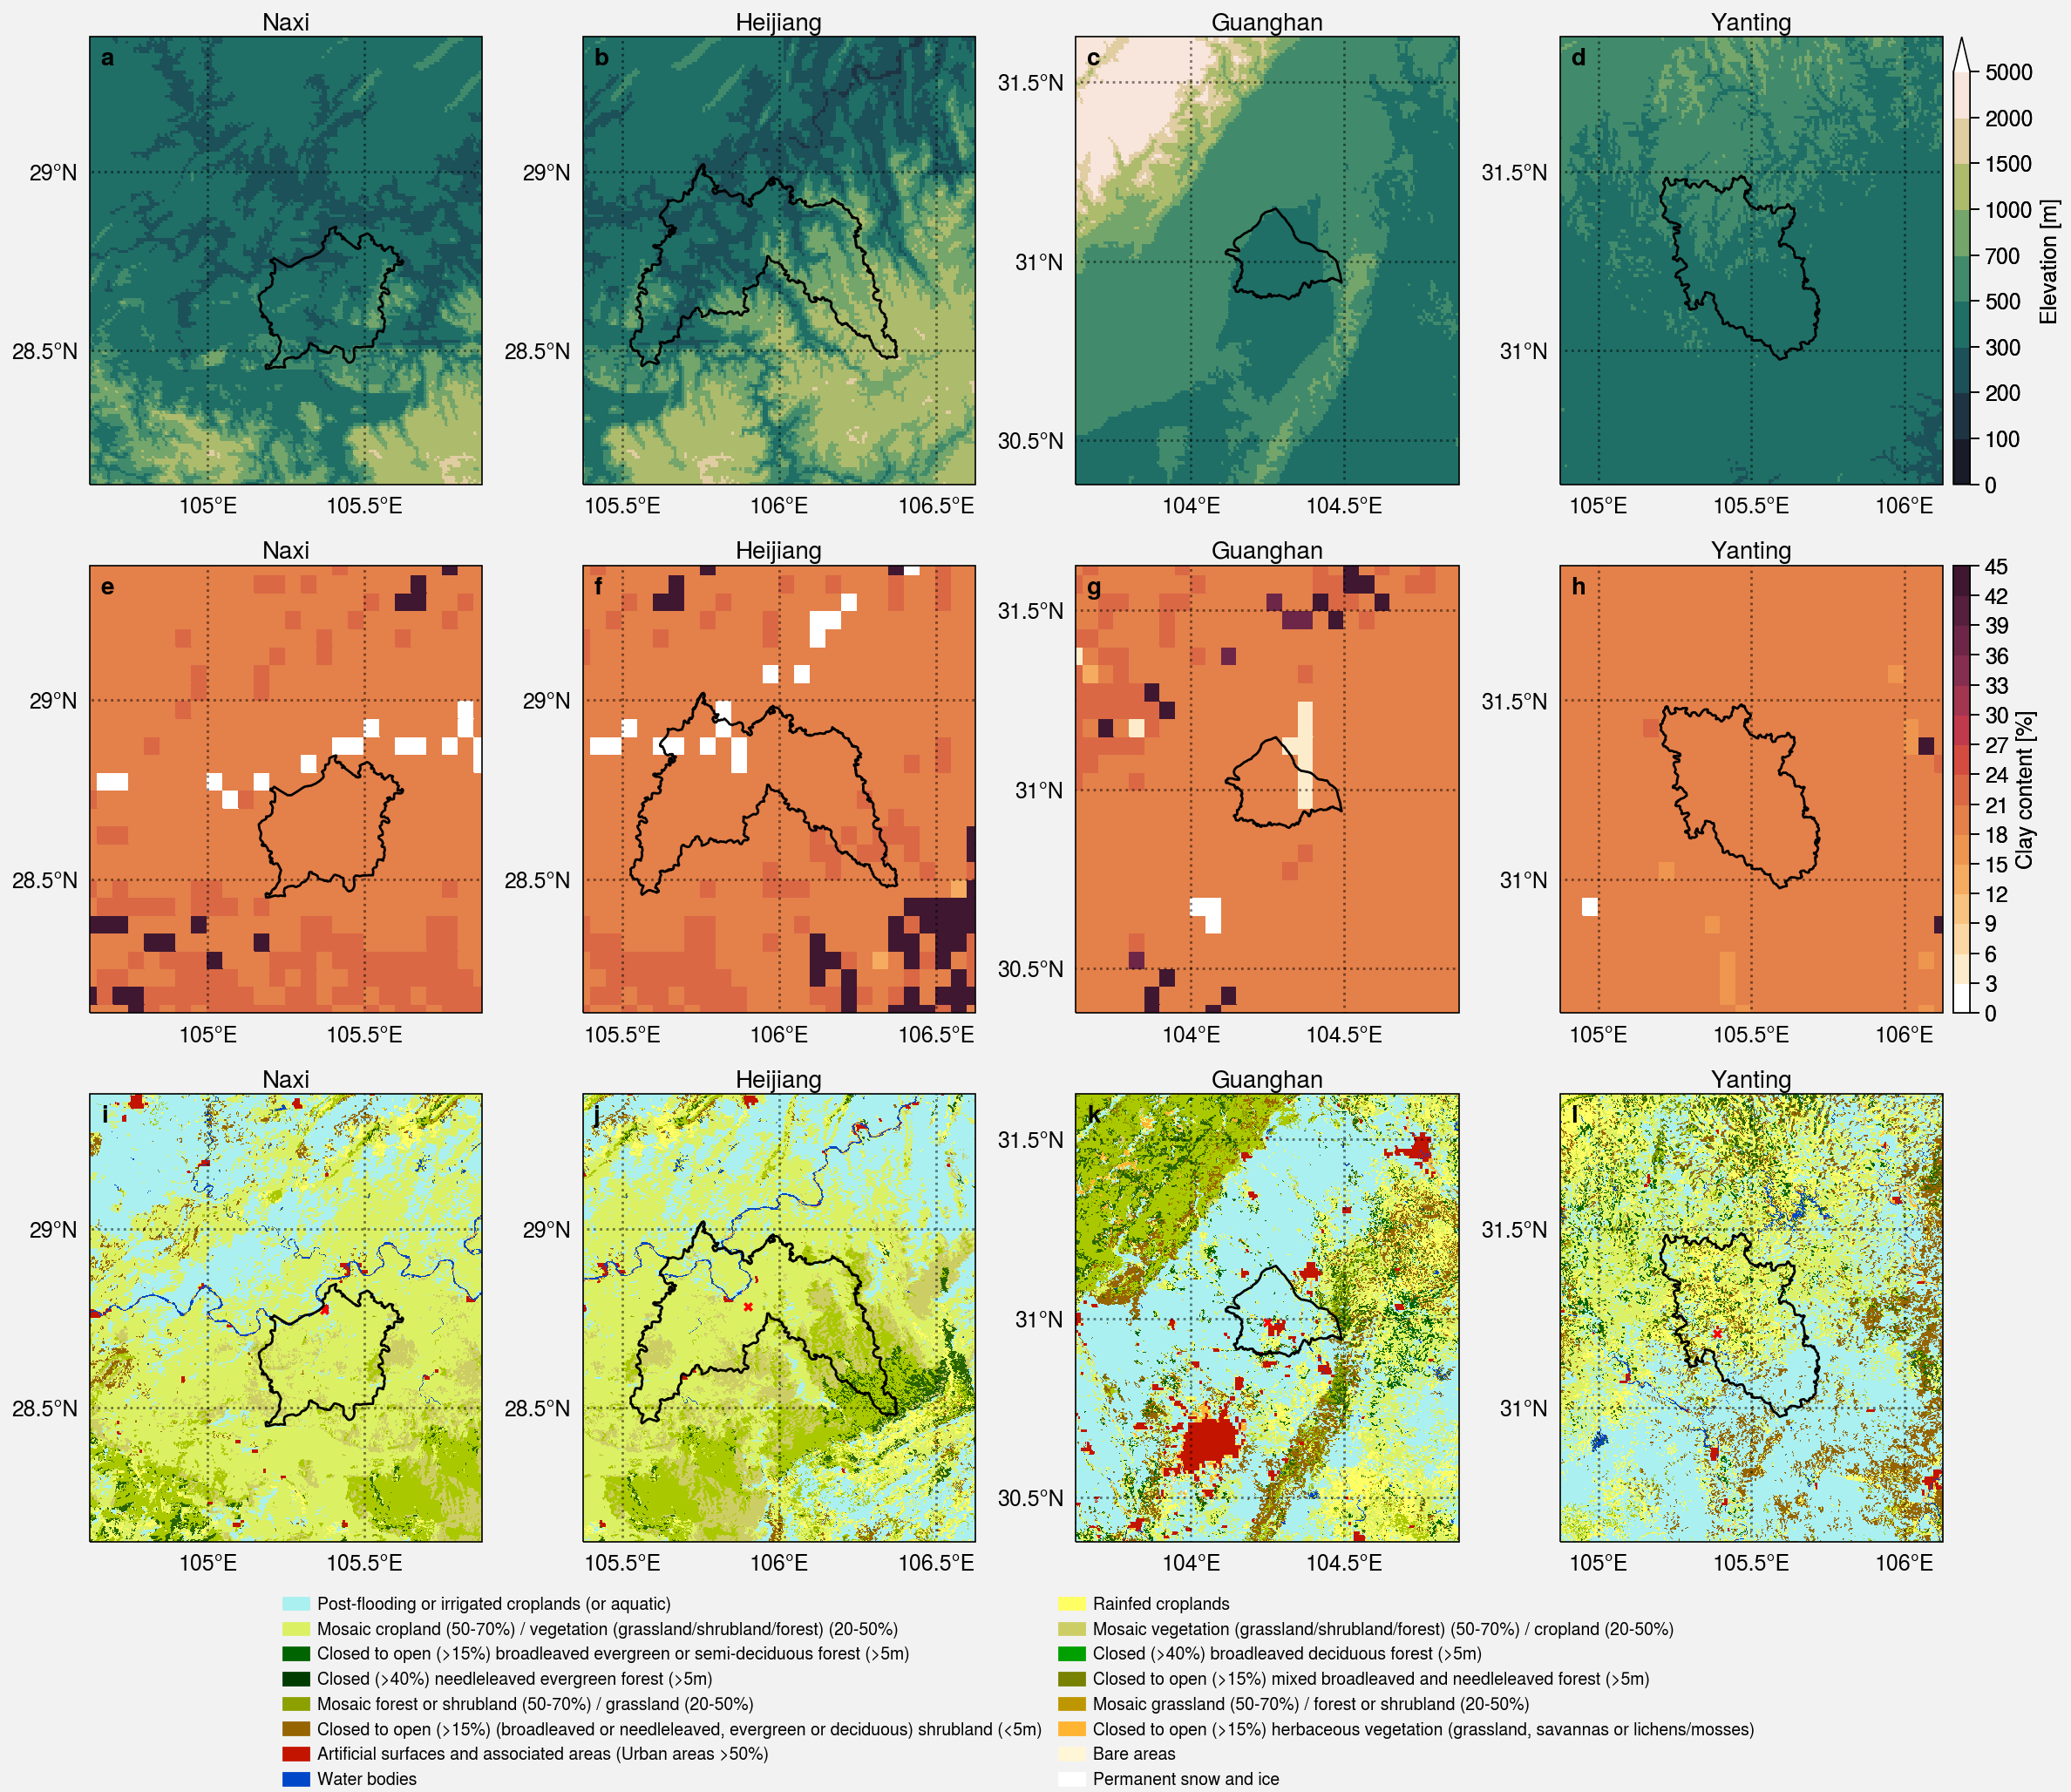

In [39]:
NCOLS = 4
NROWS = 3


f, axs = plot.subplots(ncols=NCOLS, nrows=NROWS, proj={k:mercator for k in range(1, NCOLS*NROWS+1)})


axs.format(abc=True, abcloc='ul', abcborder=False)


r = .5   # radius to plot around center coord / degrees


# Row 0 ---------------
# R = 0
# for i, region in enumerate(regions):
#     la, lo, _ = loc[region]
#     print(axs[i])
#     axs[i].set_extent((lo-r, lo+r,la-r,la+r), crs=ccrs.PlateCarree())
#     axs[i].add_image(tiler, 6)
    
    
# Row A: DEM ----------------------
R = 0

VMAX = 3000
LEVELS = [0, 100, 200, 300, 500, 700, 1000, 1500, 2000, 5000]

for i, region in enumerate(regions):
    la, lo, _ = loc[region]
    axs[i+R].pcolormesh(
        da_gtopo30.sel(lat=slice(la-2*r, la+2*r), lon=slice(lo-2*r, lo+2*r)),
        cmap='boreal_r',
        colorbar='r' if i==3 else None, 
        colorbar_kw={'label': 'Elevation [m]', 'width': '0.75em'} if i==3 else None, 
        vmin=0, vmax=VMAX, levels=LEVELS,
        extend='max',
        #linewidth=0.7, #color='gray7'
    )
    

# Row B: SOIL ---------------------- DUMMY
R += NCOLS 
VMIN = 0
VMAX = 45
for i, region in enumerate(regions):
    la, lo, _ = loc[region]
    axs[i+R].pcolormesh(
        da_soil.sel(lat=slice(la-r*2, la+r*2), lon=slice(lo-r*2, lo+r*2)),
        cmap='fire',
        colorbar='r' if i==3 else None, 
        colorbar_kw={'label': 'Clay content [%]', 'width': '0.75em'} if i==3 else None, 
        vmin=VMIN, vmax=VMAX, levels=range(VMIN, VMAX+3, 3), #levels=[0,10,20,30,40],
        #extend='both',
        #linewidth=0.7, #color='gray7'
    )

    
# Row C: LU ----------------------
R += NCOLS 

LEVELS = list(lu_legend.index.values)
COLORS = list(lu_legend.hex.values)
DISCRETE = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', COLORS, len(LEVELS))
present_lu_classes = []


for i, region in enumerate(regions):
    la, lo, _ = loc[region]
    subset = da_lu.sel(lat=slice(la-r*2, la+r*2), lon=slice(lo-r*2, lo+r*2))
    m = axs[i+R].pcolormesh(
        subset,
        cmap=DISCRETE,
        vmin=0, vmax=21, levels=LEVELS,
    )
    axs[i+R].scatter([lo], [la], color='red', marker='x')
    present_lu_classes.extend(list(np.unique(subset.values)))

# unify landuse classes from all subplots
present_lu_classes = list(set(present_lu_classes))


# ---------------------- formatting for all plots
for j in range(NROWS):
    R = j*NCOLS
    for i, region in enumerate(regions):
        la, lo, long_name = loc[region]

        # boundary
        district = gdf.loc[gdf.name == long_name]
        axs[i+R].format(
            title=regions[i],
            lonlim=(my_round(lo)-r*1.25, my_round(lo)+r*1.25), latlim=(my_round(la)-r*1.25, my_round(la)+r*1.25),
            borders=True, coast=True, ocean=True, oceancolor='lightskyblue',
            latlines=.5, lonlines=.5, labels=True,
        )
        
        axs[i+R].add_geometries(district.geometry, crs = ccrs.PlateCarree(),
                          edgecolor='black', facecolor="none", zorder = 5)
                          
        
# custom legend magic - LU classes
handles = []
for pc in list(present_lu_classes):
    row = lu_legend.loc[pc]
    
    patch = mpatches.Patch(color=row.hex, label=row.Label)
    handles.append(patch)

        
f.legend(handles=handles, frame=False, loc='b', ncols=2, fontsize=7)
f.savefig('plot_china_sites.png', facecolor='w')